## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from time_series_generation import *
from phid import *
from network_analysis import *
from hf_token import TOKEN

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Wed May 22 07:59:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A30                     Off | 00000000:01:00.0 Off |                   On |
| N/A   47C    P0             120W / 165W |  11094MiB / 24576MiB |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

## Load the Time Series

In [3]:
time_series = [load_time_series(i) for i in range(0,5)]
    # List to hold averaged attention weights for each prompt
averaged_attention_weights_per_prompt = []

for time_serie in time_series:
    # Average the attention weights across all timesteps for each prompt
    avg_attention_weights = torch.mean(time_serie["attention_weights"], axis=2)
    # Collect averaged attention weights
    averaged_attention_weights_per_prompt.append(avg_attention_weights)

category_attention_weights_tensor = torch.tensor(np.array(averaged_attention_weights_per_prompt))

# Since we want [num_layers, num_heads, num_prompts], we transpose the axes
print(category_attention_weights_tensor.shape)

torch.Size([5, 18, 8])


In [ ]:
time_series = load_time_series(0) # Load the time series for the first 1000 tokens, choose from 0 to 4

plot_attention_metrics_norms_over_time(time_series, metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, smoothing_window=10, save=False)

## Redundancy and Synergy Heatmaps

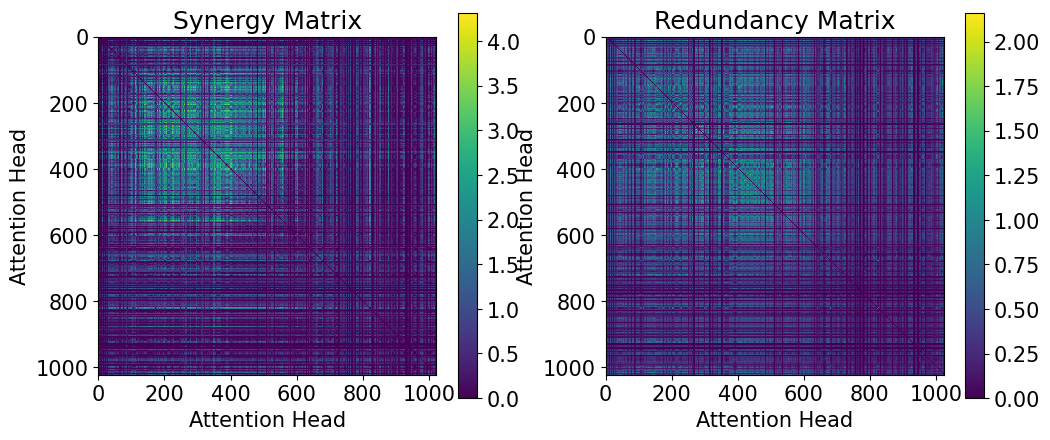

In [4]:
# time_series = [load_time_series(i) for i in range(0,5)]

# for time_serie in time_series:
global_matrices, synergy_matrices, redundancy_matrices = compute_PhiID(time_series, metrics=constants.METRICS_TRANSFORMER, save=True, kind="gaussian")
plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=False)
# plot_all_PhiID(global_matrices)

## Synergy-Redundancy Gradients

In [4]:
averages = calculate_averages_per_head(synergy_matrices, redundancy_matrices)
plot_averages_per_head(averages, save=False)

In [5]:
rank_gradients = compute_synergy_redundancy_rank_gradient(averages)
plot_synergy_redundancy_rank_gradient(rank_gradients, save=False)

In [6]:
gradient_percentiles = compute_gradient_percentile(averages)
plot_gradient_percentile(gradient_percentiles, save=False)

## Graph Connetivity

In [20]:
global_matrices, synergy_matrices, redundancy_matrices = load_matrices(0)

In [32]:
glob_eff_attention_weights = {}
glob_mod_attention_weights = {}

for i in range(0,4):
    global_matrices, synergy_matrices, redundancy_matrices = load_matrices(i)
    efficiency_results, modularity_results = compare_synergy_redundancy(synergy_matrices, redundancy_matrices, constants.METRICS_TRANSFORMER, verbose=False)
    glob_eff_attention_weights[i] = efficiency_results["attention_weights"]
    glob_mod_attention_weights[i] = modularity_results["attention_weights"]
print(glob_eff_attention_weights)
print(glob_mod_attention_weights)


{0: {'glob_eff_syn': 0.12520855535576708, 'glob_eff_red': 0.0676212957918008, 'glob_eff_syn > glob_eff_red': True}, 1: {'glob_eff_syn': 0.12441578327172555, 'glob_eff_red': 0.10624116318690546, 'glob_eff_syn > glob_eff_red': True}, 2: {'glob_eff_syn': 0.12620720104454766, 'glob_eff_red': 0.06292097989876452, 'glob_eff_syn > glob_eff_red': True}, 3: {'glob_eff_syn': 0.13571356531134962, 'glob_eff_red': 0.069839256121583, 'glob_eff_syn > glob_eff_red': True}}
{0: {'modularity_synergy': 0.09468362387190232, 'modularity_redundancy': 0.05296919517907389, 'modularity_redundancy > modularity_synergy': False}, 1: {'modularity_synergy': 0.08934863317535824, 'modularity_redundancy': 0.07101217879011162, 'modularity_redundancy > modularity_synergy': False}, 2: {'modularity_synergy': 0.10060508746386987, 'modularity_redundancy': 0.053820017916643814, 'modularity_redundancy > modularity_synergy': False}, 3: {'modularity_synergy': 0.10575878002091554, 'modularity_redundancy': 0.05009004071555845, 'm

In [33]:
# Function to compute mean and standard deviation
def compute_stats(data_dict, key):
    values = [run[key] for run in data_dict.values()]
    mean_val = np.mean(values)
    std_val = np.std(values)
    return mean_val, std_val

# Calculate for global efficiency
mean_glob_eff_syn, std_glob_eff_syn = compute_stats(glob_eff_attention_weights, 'glob_eff_syn')
mean_glob_eff_red, std_glob_eff_red = compute_stats(glob_eff_attention_weights, 'glob_eff_red')

# Calculate for modularity
mean_modularity_synergy, std_modularity_synergy = compute_stats(glob_mod_attention_weights, 'modularity_synergy')
mean_modularity_redundancy, std_modularity_redundancy = compute_stats(glob_mod_attention_weights, 'modularity_redundancy')

# Print the results
print("Global Efficiency - Synergy: Mean =", mean_glob_eff_syn, ", SD =", std_glob_eff_syn)
print("Global Efficiency - Redundancy: Mean =", mean_glob_eff_red, ", SD =", std_glob_eff_red)
print("Modularity - Synergy: Mean =", mean_modularity_synergy, ", SD =", std_modularity_synergy)
print("Modularity - Redundancy: Mean =", mean_modularity_redundancy, ", SD =", std_modularity_redundancy)


Global Efficiency - Synergy: Mean = 0.12788627624584747 , SD = 0.004563448758755599
Global Efficiency - Redundancy: Mean = 0.07665567374976345 , SD = 0.017262868640415763
Modularity - Synergy: Mean = 0.0975990311330115 , SD = 0.0061681954925189054
Modularity - Redundancy: Mean = 0.056972858150346944 , SD = 0.00822261239803919
